## Part2: Supervised Learning Model

In [14]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

from clean_data import clean_data
from preprocess_fit import preprocess_fit

# magic word for producing visualizations in notebook
%matplotlib inline

In [6]:
# Load feature info
feat_info = pd.read_csv('features.csv')
feat_info.set_index('attribute', inplace=True)

# Parse missing_or_known string into a list
def parse_missing(s):
    a = s[1:-1].split(',')
    return a

feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(parse_missing)

## Cluster mailout data

In [2]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\Mei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
mailout_train.shape

(42962, 367)

In [4]:
mailout_train.RESPONSE.value_counts()/mailout_train.shape[0]

0    0.987617
1    0.012383
Name: RESPONSE, dtype: float64

In [18]:
y = mailout_train.RESPONSE
X = mailout_train.drop('RESPONSE', axis=1)

X_clean, X_dropped = clean_data(X, feat_info, row_threshold=len(mailout_train.columns))

In [21]:
X_clean.shape

(42962, 135)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
y_train.value_counts()

0    33943
1      426
Name: RESPONSE, dtype: int64

### Try applying clustering

In [15]:
# Load model
clust_model = joblib.load('clust_model5.pkl')

In [16]:
X_train_labels = clust_model.predict(X_train)

ValueError: X has 135 features per sample, expected 136

In [23]:
print(X_train.shape)
print(len(X_train_labels))
X_combined = pd.DataFrame({'RESPONSE':y_train, 'Cluster':X_train_labels})
X_combined.head()

(34369, 76)
34369


,RESPONSE,Cluster
25923,0,5
14938,0,2
1928,0,5
20513,0,1
2325,0,5


In [24]:
p_yes = X_combined[X_combined.RESPONSE == 1].Cluster.value_counts() / X_combined[X_combined.RESPONSE == 1].Cluster.value_counts().sum()
print(p_yes)
p_no = X_combined[X_combined.RESPONSE == 0].Cluster.value_counts() / X_combined[X_combined.RESPONSE == 0].Cluster.value_counts().sum()
print(p_no)

5    0.413146
1    0.192488
3    0.161972
0    0.115023
2    0.110329
4    0.007042
Name: Cluster, dtype: float64
5    0.361930
1    0.210971
3    0.174616
2    0.136788
0    0.105117
4    0.010577
Name: Cluster, dtype: float64


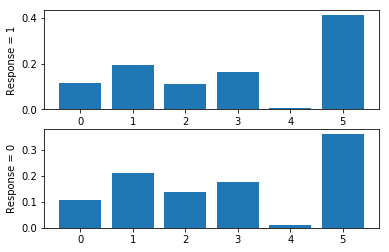

In [25]:
plt.subplot(2, 1, 1)
ax1 = plt.bar(p_yes.index, p_yes)
plt.ylabel('Response = 1')

plt.subplot(2, 1, 2)
ax1 = plt.bar(p_no.index, p_no)
plt.ylabel('Response = 0')

plt.show()

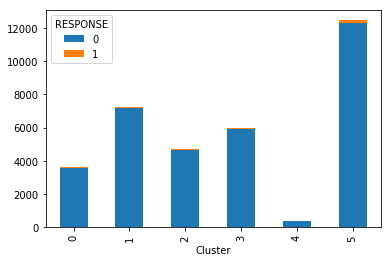

In [26]:
counts = X_combined.groupby('RESPONSE').Cluster.value_counts().unstack(0)
counts.plot.bar(stacked=True);

In [27]:
p_response = counts.apply(lambda x: x/X_combined.Cluster.value_counts().sort_index())
p_response

RESPONSE,0,1
Cluster,,
0,0.986453,0.013547
1,0.988679,0.011321
2,0.989979,0.010021
3,0.988492,0.011508
4,0.991713,0.008287
5,0.985876,0.014124


In [28]:
X_combined.RESPONSE.value_counts() / X_combined.shape[0]

0    0.987605
1    0.012395
Name: RESPONSE, dtype: float64

### AdaBoost

In [46]:
ada = AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced'), algorithm='SAMME.R')
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [47]:
y_preds = ada.predict(X_test)
print(classification_report(y_test, y_preds))
print(roc_auc_score(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      8487
           1       0.02      0.08      0.03       106

   micro avg       0.95      0.95      0.95      8593
   macro avg       0.50      0.52      0.50      8593
weighted avg       0.98      0.95      0.96      8593

0.5158788913565919


In [31]:
# Dealing with the class imbalance
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids()
X_resampled, y_resampled = cc.fit_sample(X_train, y_train)

In [32]:
pd.value_counts(y_resampled)

1    426
0    426
dtype: int64

In [33]:
ada.fit(X_resampled, y_resampled)
y_preds = ada.predict(X_test)
roc_auc_score(y_test, y_preds)

0.5124118796561223

In [43]:
ada.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator__class_weight': 'balanced',
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': False,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(class_weight='balanced', criterion='gini',
             max_depth=None, max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 

In [48]:
# Improving the model
parameters = {
    'base_estimator__class_weight':[None],
    'base_estimator__max_depth':[50, 100, None],
    'n_estimators':[50, 100],
    'learning_rate':[.75, 1]
}

cv = GridSearchCV(ada, parameters, cv=3, scoring='roc_auc')
cv.fit(X_resampled, y_resampled)
print(cv.best_params_)

{'base_estimator__class_weight': None, 'base_estimator__max_depth': 50, 'learning_rate': 1, 'n_estimators': 50}


In [49]:
y_preds = cv.predict(X_test)
roc_auc_score(y_test, y_preds)

0.5334006949585492

### Keras

In [38]:
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization

Using TensorFlow backend.


In [39]:
def make_model(n_features):
    model = Sequential()
    model.add(Dense(50, input_shape=(n_features,),
              kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Dense(25, kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=.0001),
                  metrics=['accuracy'])

    return model

In [56]:
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import ClusterCentroids, NearMiss

def fit_predict_balanced_model(X_train, y_train, X_test, y_test):
    model = make_model(X_train.shape[1])
    training_generator = BalancedBatchGenerator(X_train, y_train,
                                                random_state=42)
    model.fit_generator(generator=training_generator, epochs=50, verbose=False)
#    model.fit(X_train, y_train, epochs=50, verbose=True)
    y_pred = model.predict_proba(X_test)
    return roc_auc_score(y_test, y_pred)

In [57]:
roc_auc = fit_predict_balanced_model(X_train, y_train, X_test, y_test)
roc_auc

0.5217913745995539

With balanced batches: 0.5217913745995539
Without balanced batches: 0.5185533479616995

### Try adding the cluster labels

In [149]:
X_pca_labels = clust_model.predict(X_pca)

In [150]:
clusters_scaled = (X_pca_labels - X_pca_labels.mean()) / X_pca_labels.std()

clusters_scaled = clusters_scaled.reshape(-1, 1)
clusters_scaled.shape

(42962, 1)

In [155]:
X_clustered = np.append(X_pca, clusters_scaled, axis=1)
X_clustered.shape

(42962, 77)

In [158]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clustered, y, test_size=0.2, random_state=42, stratify=y)
print(X_train_c.shape)
print(X_test_c.shape)

(34369, 77)
(8593, 77)


In [159]:
roc_auc = fit_predict_balanced_model(X_train_c, y_train_c, X_test_c, y_test_c)
roc_auc

0.5597373118932174